# Active Subspaces Applied to Wind Turbine Fatigue

__Paul Constantine__, Colorado School of Mines, <pconstan@mines.edu>

__Ryan Howard__, Colorado School of Mines, <ryhoward@mines.edu>

### Introduction

Offshore wind turbines are a method of power generation currently being researched. What we know about land turbines can't be applied directly to offshore turbines because of the differences in operating conditions. We'd like to know more about the loads on these turbines across a variety of conditions to better estimate durability, reliability, and lifespan. Since building turbines is expensive, we must use simulations to guide our exploration. These simulations can be expensive to run and often have a high-dimensional parameter space. The number of model evaluations required for parameter studies grows exponentially with dimension; combined with the expense of the model, this can pose challenges to our exploration. One approach to this problem is dimension reduction: examining our quantities of interest in fewer dimensions than the full parameter space. In this notebook, we'll discuss the _active subspaces_ method of dimension reduction and apply it to a model of an offshore wind turbine. The model and data are found in [3]. 

### Active Subspaces

Consider our scalar quantity of interest as a function of normalized parameters, $f(\mathbf x)$. The active subspaces methodology looks for the most 'important' directions in the parameter space (the span of which is the active subspace), along which $f$ tends to change more than in the orthogonal directions. If $f$ is reasonably flat in the orthogonal directions, it could be reasonable to examine it only in the active subspace. The method is based on the matrix

$$
\mathbf C = \int\nabla f(\mathbf x)\nabla f(\mathbf x)^T\rho(\mathbf x)\ d\mathbf x,
$$

where $\nabla f(\mathbf x)$ is the gradient of $f$ with respect to the parameters $\mathbf x$ and $\rho(\mathbf x)$ is a probability density function. $\mathbf C$ is positive semidefinite, so it has an eigendecomposition: $\mathbf C = \mathbf W\Lambda\mathbf W^T$, where $\Lambda$ is a diagonal matrix containing $\mathbf C$'s eigenvalues in descending order and $\mathbf W$'s columns are the corresponding eigenvectors. We can partition the decomposition as 

$$
\mathbf W = \left[\begin{matrix}\mathbf W_1 & \mathbf W_2\end{matrix}\right],\ \Lambda = \left[\begin{matrix}\Lambda_1 & \\ & \Lambda_2\end{matrix}\right],
$$

where $\Lambda_1$ contains the first $n$ eigenvalues and $\mathbf W_1$ the corresponding eigenvectors. Each eigenvalue quantifies how much $f$ changes, on average, along the direction defined by the corresponding eigenvector; if the first $n$ eigenvalues are large compared to the rest, $f$ will likely be relatively flat in the subspace defined by $\mathbf W_2$.

### Our Wind Turbine Data

We can simulate loads on wind turbines with physics simulations such as TurbSim (which simulates turbulent wind) and FAST (which simulates turbine behavior). The model we use has 5 inputs, which are summarized in the table below.

Variable Name | Symbol | Distribution
:-------------|:------:|:------------
Wind Speed | $V_{hub}$ | Weibull
Wave Direction | $\theta_w$ | Von Mises conditioned on $V_{hub}$
Wave Height | $H_s$ | Gamma conditioned on $V_{hub}$ and $\theta_w$
Wave Period | $T_p$ | Gamma conditioned on $V_{hub}$ and $H_s$
Wind-Platform Direction | $\theta_p$ | Von Mises conditioned on $V_{hub}$

The physics simulations output many quantities related to the load borne by various components of the turbine; we examine 7 for demonstration. The dataset has nearly 500,000 pairs of inputs and corresponding outputs.

### References

[[1]][R1] P.G. Constantine, E. Dow, and Q. Wang. _Active subspaces in theory and practice: applications to kriging surfaces_. SIAM J. Sci. Comput., 36(4), A1500–A1524, 2014

[[2]][R2] P.G. Constantine. _Active Subspaces: Emerging Ideas for Dimension Reduction in Parameter Studies_. SIAM, 2015

[[3]][R3] P.A. Graf, G. Stewart, M. Lackner, K. Dykes, and P. Veers. _High-throughput computation and the applicability of Monte Carlo integration in fatigue load estimation of floating offshore wind turbines_. Wind Energy, 19(5), 861-872, 2016

[R1]: http://dx.doi.org/10.1137/130916138
[R2]: http://dx.doi.org/10.1137/1.9781611973860
[R3]: http://dx.doi.org/10.1002/we.1870

### Acknowledgments

This material is based upon work supported by the U.S. Department of Energy Office of Science, Office of Advanced Scientific Computing Research, Applied Mathematics program under Award Number DE-SC-0011077.

<br>

We'll demonstrate the active subspace methodology using using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces).

In [1]:
%matplotlib inline
import numpy as np
import active_subspaces as ac
import matplotlib.pyplot as plt
import pandas as pn

In [2]:
#Load in the data
data = pn.DataFrame.from_csv('NRELwind_testing.txt'); keys = data.keys()
data = data.as_matrix()

#Normalized inputs
XX = data[:,:5]
#Output values
f = data[:,5:]

#Labels for inputs, outputs
in_labels = keys[:5]; out_labels = keys[5:]

Recall that the matrix $\mathbf C$ is based on the gradient of $f$. One way of approximating $\mathbf C$ is with simple Monte Carlo: draw many $\mathbf x$'s according to $\rho$, compute $\nabla f$ at each point, and use these to approximate $\mathbf C$. However, we do not have access to gradients for these samples, so we'll need to use a different approach. One such approach is to fit linear models at many points using several of its nearest neighbors and using the resulting gradients to compute the subspace. We compute such subspaces for each output below and construct sufficient summary plots (plots of the active variable(s), $\mathbf W_1^T\mathbf x$, against the output, $f$), as well as presenting the first few eigenvectors.

In [3]:
subspaces = []
for i in range(f.shape[1]):
    ss = ac.subspaces.Subspaces()
    df = ac.gradients.local_linear_gradients(XX, f[:,i][:,None], 60)
    ss.compute(df=df, nboot=100)
    subspaces.append(ss)

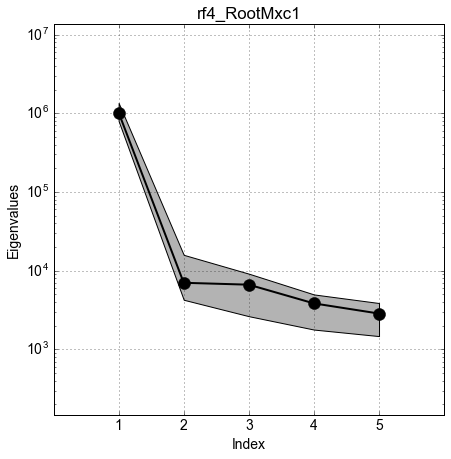

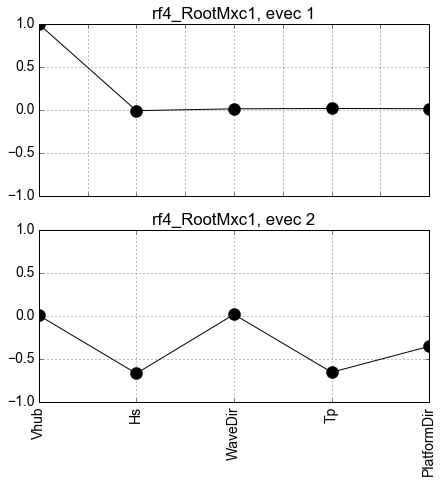

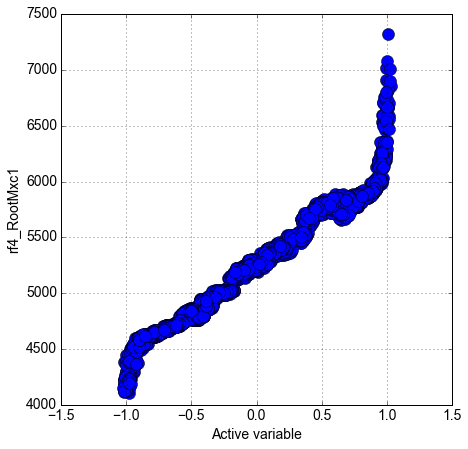

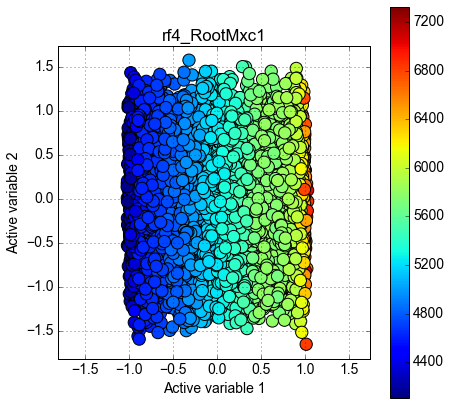

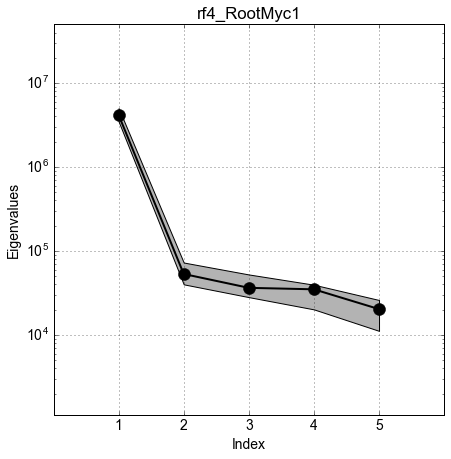

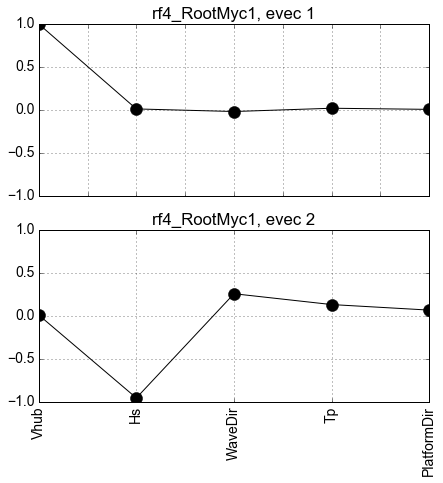

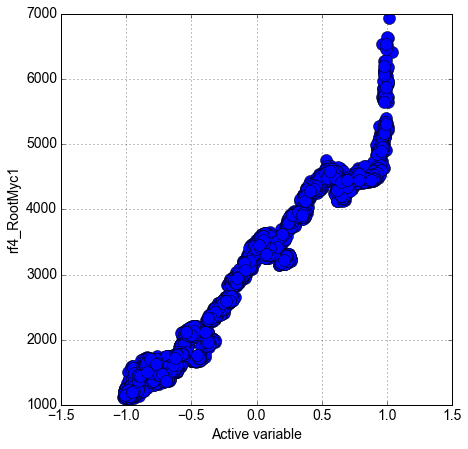

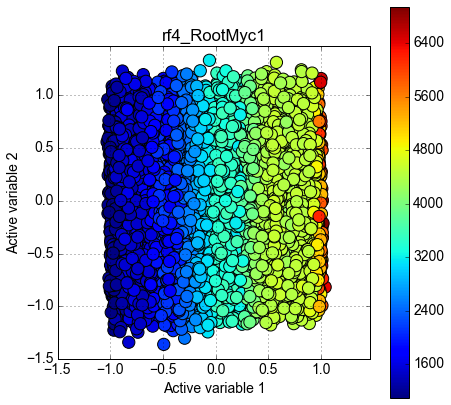

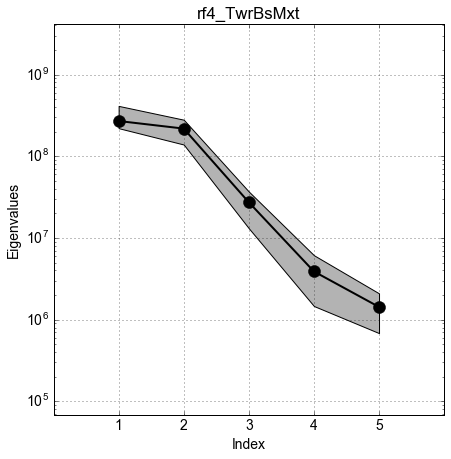

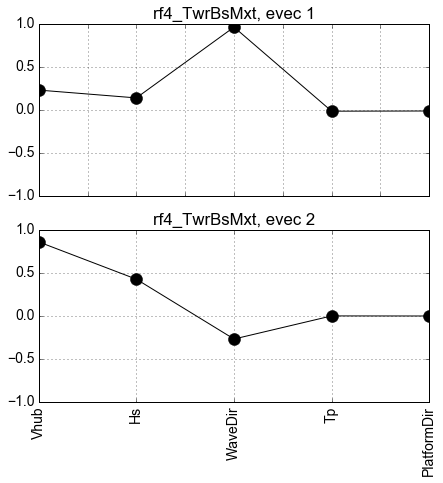

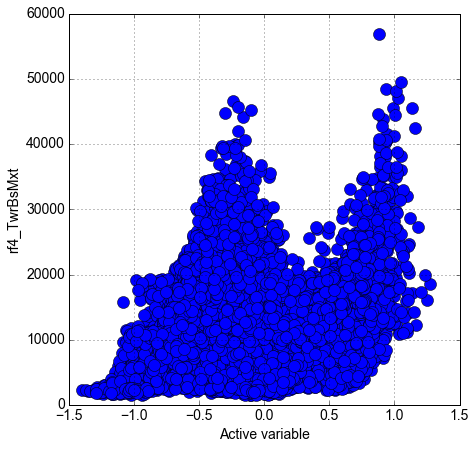

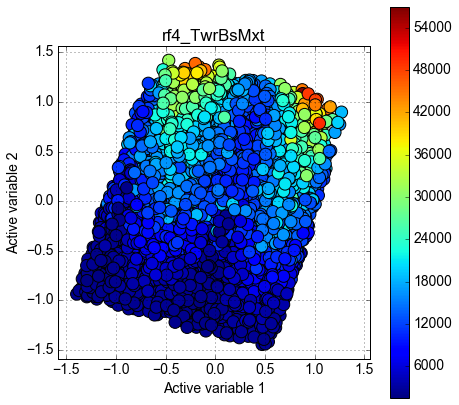

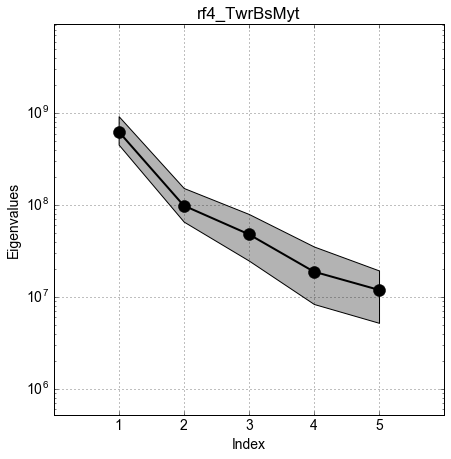

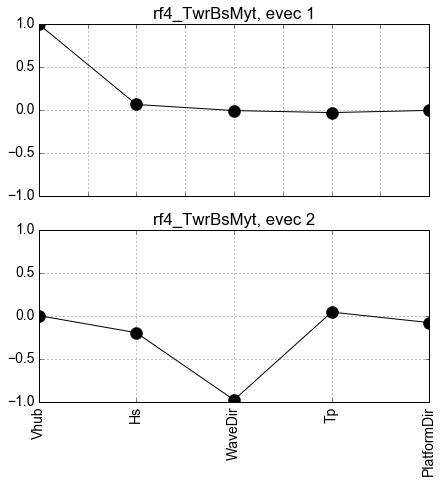

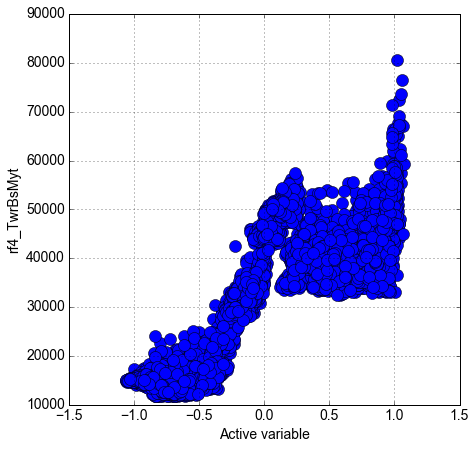

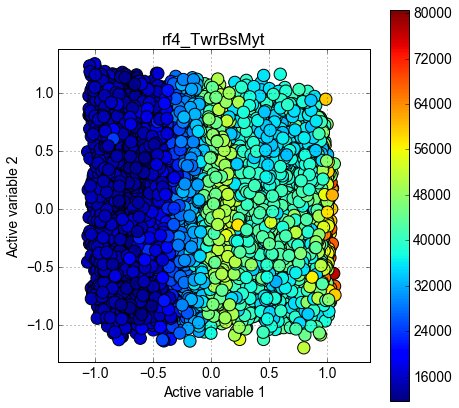

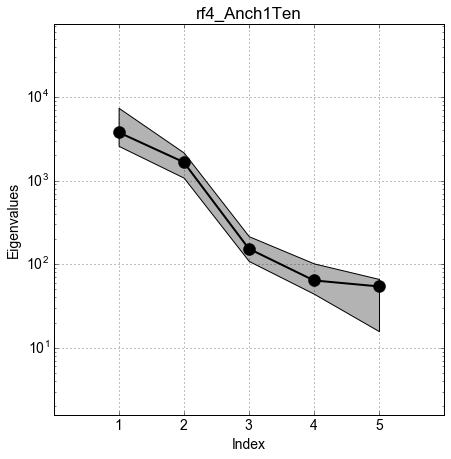

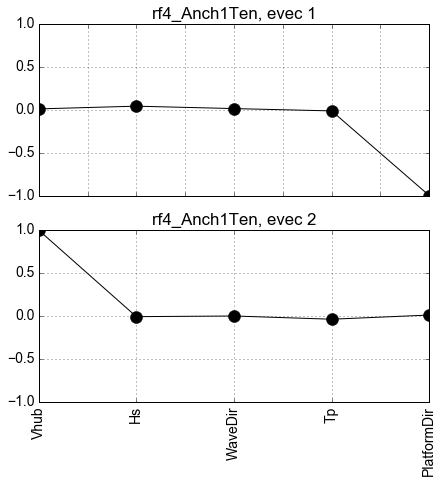

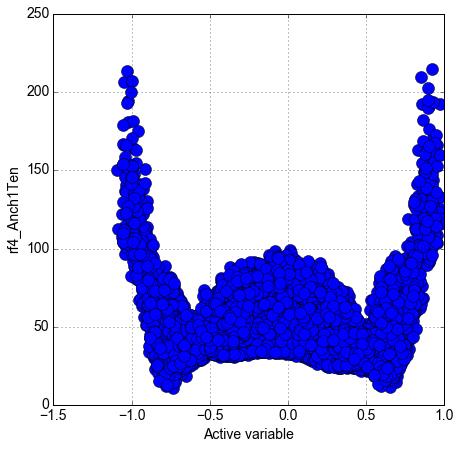

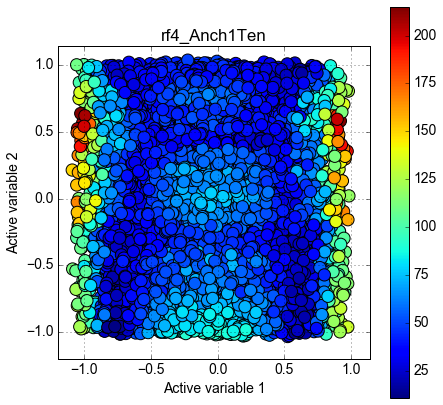

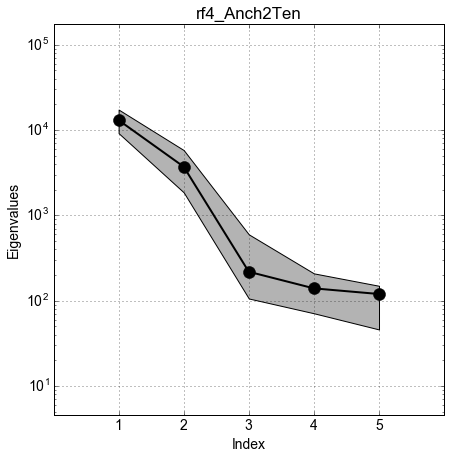

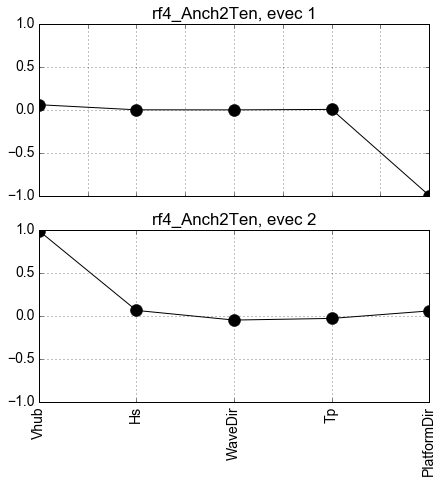

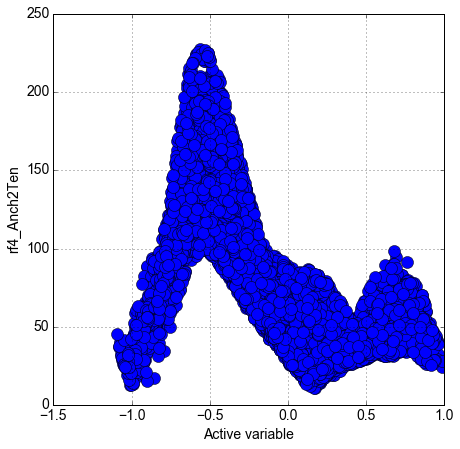

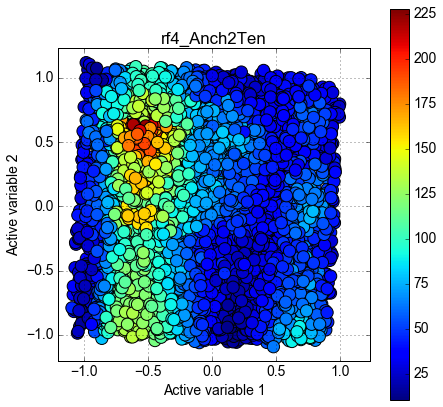

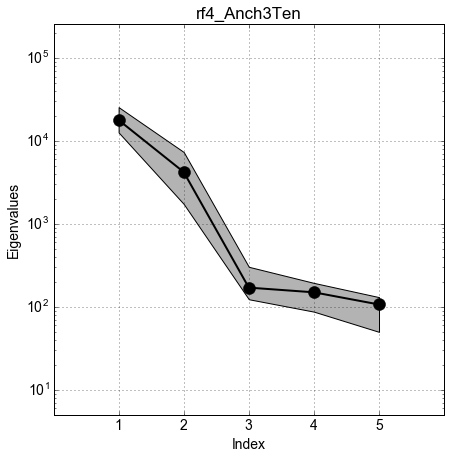

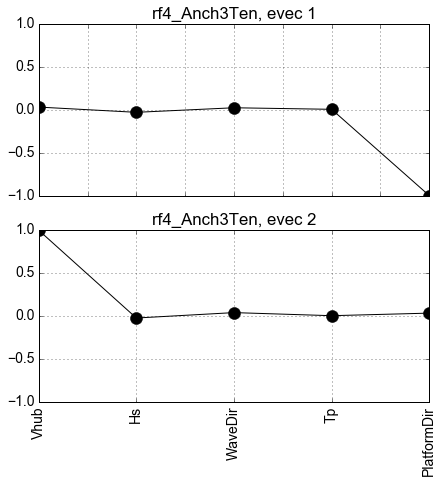

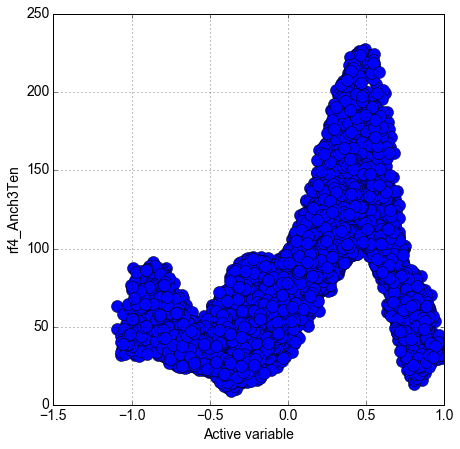

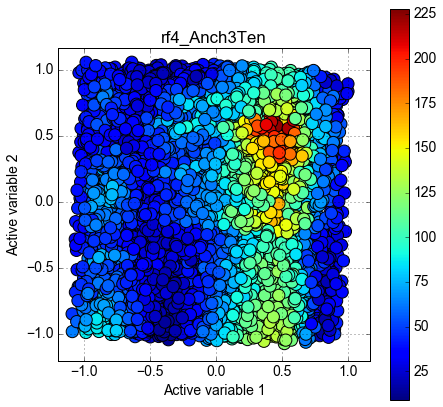

In [4]:
mask = np.random.choice(range(XX.shape[0]), 10000, False)
for i in range(f.shape[1]):
    ss = subspaces[i]
    ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br, out_labels[i])
    ss.partition(2)
    ac.utils.plotters.eigenvectors(ss.W1, in_labels=in_labels, out_label=out_labels[i])
    ac.utils.plotters.sufficient_summary(XX.dot(ss.W1)[mask], f[mask,i], out_labels[i])

The eigenvectors provide a measure of global sensitivity; higher-magnitude components indicate relative sensitivity to the corresponding parameter. For example, the tight trend of rf4_RootMxc1 and the first eigenvector placing almost all its weight on $V_{hub}$ indicate that this output is nearly a univariate function of $V_{hub}$. We can see a few fairly tight trends in the summary plots, indicating useful active subspaces. However, some of the outputs don't have a tight trend, indicating a higher-dimensional subspace is required to characterize them. Large gaps in the eigenvalues indicate accuracy in estimating the active subspace. Based on the eigenvalue decay, we choose subspace dimensions of 1, 1, 3, 3, 2, 2, and 2 for the outputs, in the order presented above.

One way to use active subspaces is surrogate modelling: fitting polynomial or radial-basis approximations with the pairs $\{(\mathbf W_1^T\mathbf x_i,\ f_i)\}_{i=1}^N$, where $N$ is the number of data points we have. For each output, we fit cubic, quartic, and quintic polynomial surrogate models. For visualization, we plot true values against values predicted by the response surface; if the fit is good, the trend should be tight around the line $y = x$. This visualization method is useful because it does not depend on the dimensionality of the domain of the surrogate model. We also list $R^2$ values as a numerical measure of goodness-of-fit.

R^2 values for surrogate models:

                 Cubic Model   Quartic Model  Quintic Model 
rf4_RootMxc1       0.9745         0.9751         0.9825     
rf4_RootMyc1       0.9693          0.972          0.975     
rf4_TwrBsMxt        0.732          0.868         0.9403     
rf4_TwrBsMyt       0.7958          0.903          0.92      
rf4_Anch1Ten        0.209         0.7271         0.7456     
rf4_Anch2Ten        0.761         0.8628         0.8719     
rf4_Anch3Ten       0.7712         0.8483         0.8586     


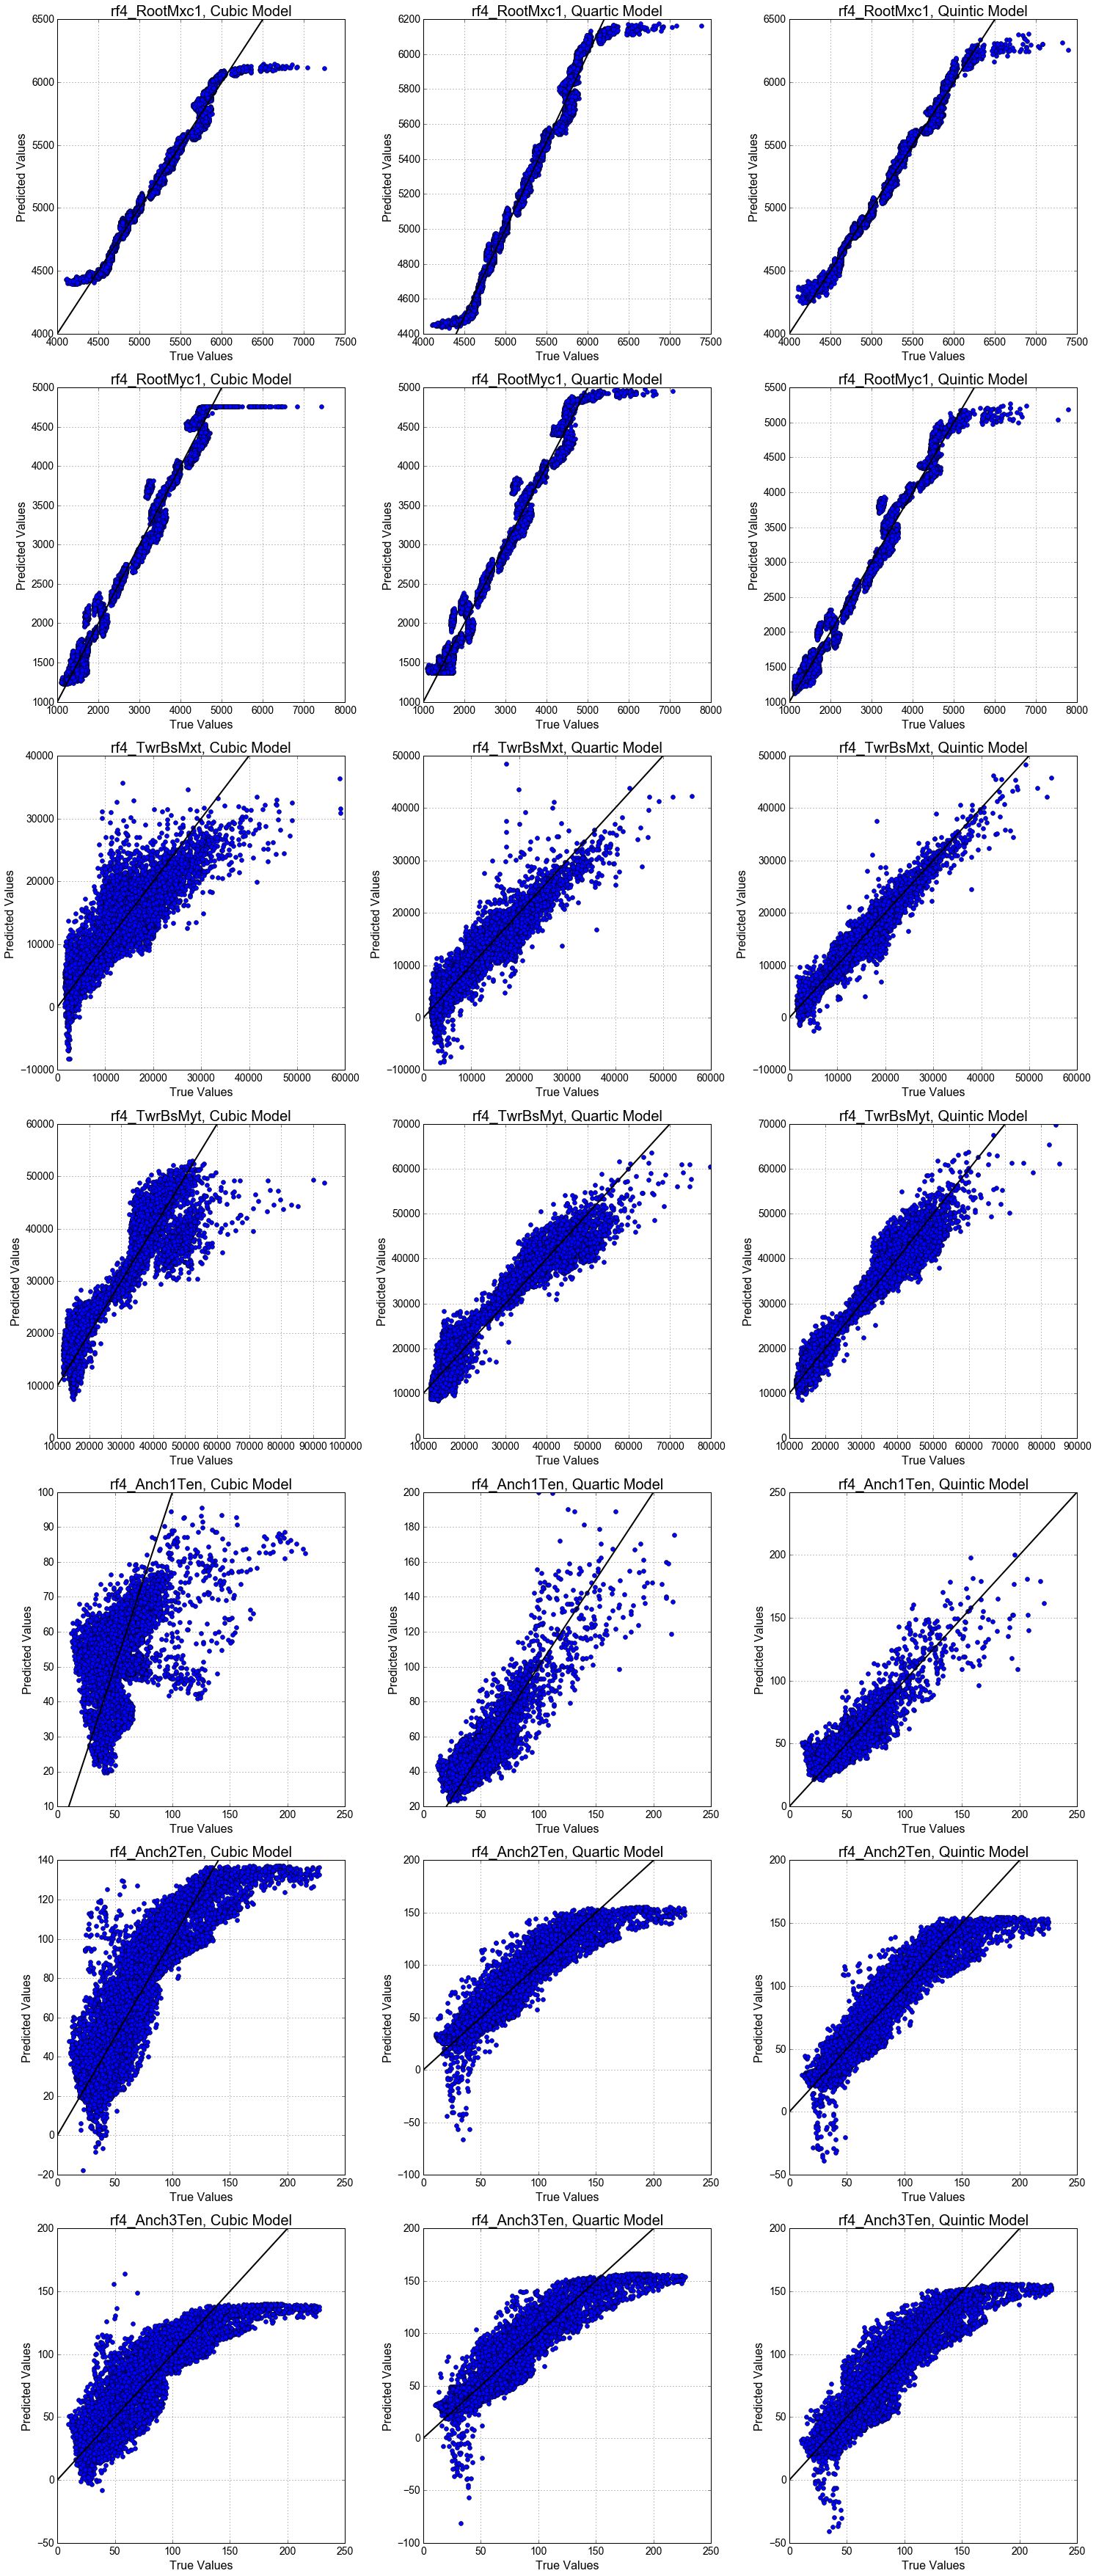

In [5]:
partitions = [1, 1, 3, 3, 2, 2, 2]

RS3 = ac.utils.response_surfaces.PolynomialApproximation(3)
RS4 = ac.utils.response_surfaces.PolynomialApproximation(4)
RS5 = ac.utils.response_surfaces.PolynomialApproximation(5)
RS = [RS3, RS4, RS5]

Rsqr = [[], [], [], [], [], [], []]

fig, axes = plt.subplots(7, 3, figsize=(3*7, 7*7)); axes = axes.reshape(21).squeeze()

models = ['Cubic Model', 'Quartic Model', 'Quintic Model']

for i in range(7):
    ss = subspaces[i]
    ss.partition(partitions[i])
    y = XX.dot(ss.W1)
    for j in range(3):
        plot_ind = i*3 + j
        RS[j].train(y, f[:,i][:,None])
        mask = np.random.choice(range(XX.shape[0]), 10000, False)
        
        axes[plot_ind].plot(f[mask,i], RS[j].predict(y[mask])[0], 'bo')
        axes[plot_ind].set_autoscale_on(False)
        axes[plot_ind].plot(axes[plot_ind].get_xlim(), axes[plot_ind].get_xlim(), 'k-',
                            linewidth=2)
        axes[plot_ind].set_xlabel('True Values', fontsize=16)
        axes[plot_ind].set_ylabel('Predicted Values', fontsize=16)
        axes[plot_ind].set_title(out_labels[i] + ', ' + models[j], fontsize=20)
        axes[plot_ind].grid(True)
        Rsqr[i].append(RS[j].Rsqr)
fig.tight_layout()

print 'R^2 values for surrogate models:\n'
print '{:<15}{:^15}{:^15}{:^15}'.format('', *models)
for i in range(7):
    print '{:<15}{:^15.4}{:^15.4}{:^15.4}'.format(out_labels[i], *Rsqr[i])

We can see mostly tight trends in the graphs, with only one case (rf4_Anch1Ten) where the models have poor and inconsistent performance across the range of true values. This is confirmed by the $R^2$ values; rf4_Anch1Ten's $R^2$ maxes out at under 0.80 while the rest have values above 0.80 (for the quintic model), and 4 outputs have values above 0.90 (for the quintic model).

### Conclusions

Overall, most of outputs we examine have useful active subspaces. The surrogate models developed for these outputs could be used in such applications as optimization, integration, and inversion. While our dataset has enough data that more traditional methods could be reasonably employed in only 5 dimensions, higher-dimensional or more expensive models could make that kind of full parameter study infeasible. Our explorations here show that active subspaces can be a way to reduce dimension to make such studies possible.